NYC's *Stop, Question, and Frisk* is a program/practice by the New York Police Department in which officers approach, temporarily detain, and (in some cases) frisk civilians on the street for weapons or contraband.  The program's implementation has been highly controversial with accusations of racial profiling and bias, and in 2013 a US federal judge found that the program had been carried out in a way that violated the US Constitution.  Using publicly available Stop and Frisk [data](https://www1.nyc.gov/site/nypd/stats/reports-analysis/stopfrisk.page), in this assignment you will expore the ability of Random Forest models to predict whether, for those stops in which a suspect was suspected of having a weapon, a weapon is likely to have been found (an analysis related to the one carried out in [Goel, Rao, & Shroff, 2016](https://projecteuclid.org/journals/annals-of-applied-statistics/volume-10/issue-1/Precinct-or-prejudice-Understanding-racial-disparities-in-New-York-Citys/10.1214/15-AOAS897.full)).

<b>

---

### **Part 1 - Loading and Cleaning data**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# -- useful imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn import tree
import graphviz

In [ ]:
# Replace 'path_to_file' with the actual path to your CSV file
file_path = '/content/drive/Shareddrives/mlpp24/data/stop_and_frisk/2010.csv'

# Read the CSV file into a DataFrame
sqf = pd.read_csv(file_path, low_memory=False)

print(sqf.head())


   year  pct  ser_num  datestop  timestop recstat inout trhsloc  perobs  \
0  2010   78       81   1012010       340       1     O       P       1   
1  2010   26       21   1042010      1548       1     O       P       2   
2  2010   18       34   1092010      1550       1     I       T       1   
3  2010  108      102   1112010      1120       A     O       P       5   
4  2010   23     2437   1222010      1620       1     O       H       1   

   crimsusp  ...  zip addrpct sector beat post   xcoord  ycoord dettypcm  \
0      MISD  ...           78                    995504  189189       CM   
1   ROBBERY  ...           26      F             998641  236979       CM   
2      MISD  ...           18      H                                  CM   
3  BURGLARY  ...          108      G            1009146  209683       CM   
4       CPM  ...           23                                         CM   

   linecm  detailcm  
0       1        20  
1       1        85  
2       1        20  
3   

**Looking at the "Data Dictionary" in the link above (i.e., the SQF file documentation found** [here](https://www1.nyc.gov/assets/nypd/downloads/zip/analysis_and_planning/stop-question-frisk/SQF-File-Documentation.zip)**) drop all columns except:**

<b>

1. the period of observation
2. whether the stop was made inside or outside
3. columns that indicate that a weapon was found on the subject
4. columns related to whether the subject was suspected of carrying a weapon
5. the subject's sex
6. the subject's age
7. the subject's race

</b>

In [ ]:
# List of columns to keep
columns_to_keep = [
    'perobs',    # Period of observation
    'inout',     # Inside or outside
    # Columns indicating a weapon was found
    'contrabn', 'pistol', 'riflshot', 'asltweap', 'knifcuti', 'machgun', 'othrweap',
    # Columns related to suspected weapon
    'sb_hdobj', 'sb_outln', 'sb_admis',
    'cs_objcs',
    'sex',       # Subject's sex
    'age',       # Subject's age
    'race'       # Subject's race
]

# Filter the DataFrame to keep only the specified columns
filtered_sqf = sqf[columns_to_keep]

# Display the first few rows of the filtered DataFrame
print(filtered_sqf.head())

   perobs inout contrabn pistol riflshot asltweap knifcuti machgun othrweap  \
0       1     O        N      N        N        N        N       N        N   
1       2     O        N      N        N        N        N       N        N   
2       1     I        N      N        N        N        N       N        N   
3       5     O        N      N        N        N        N       N        N   
4       1     O        N      N        N        N        N       N        N   

  sb_hdobj sb_outln sb_admis cs_objcs sex  age race  
0        N        N        N        N   M   17    B  
1        N        N        N        N   M   20    P  
2        Y        N        N        N   M   55    Q  
3        N        N        N        N   M   17    Q  
4        N        N        N        N   M   55    B  


**Convert all binary columns (i.e., columns with categories that only have two possible values) to 1s and 0s.**

In [ ]:
binary_mapping = {'Y': 1, 'N': 0}

binary_columns = ['inout', 'contrabn', 'pistol', 'riflshot', 'asltweap', 'knifcuti', 'machgun', 'othrweap',
                  'sb_hdobj', 'sb_outln', 'sb_admis', 'cs_objcs']

filtered_sqf[binary_columns] = filtered_sqf[binary_columns].applymap(lambda x: binary_mapping.get(x, x))

print(filtered_sqf.head())

   perobs inout  contrabn  pistol  riflshot  asltweap  knifcuti  machgun  \
0       1     O         0       0         0         0         0        0   
1       2     O         0       0         0         0         0        0   
2       1     I         0       0         0         0         0        0   
3       5     O         0       0         0         0         0        0   
4       1     O         0       0         0         0         0        0   

   othrweap  sb_hdobj  sb_outln  sb_admis  cs_objcs sex  age race  
0         0         0         0         0         0   M   17    B  
1         0         0         0         0         0   M   20    P  
2         0         1         0         0         0   M   55    Q  
3         0         0         0         0         0   M   17    Q  
4         0         0         0         0         0   M   55    B  


<ipython-input-5-0156cc50c0c8>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_sqf[binary_columns] = filtered_sqf[binary_columns].applymap(lambda x: binary_mapping.get(x, x))


**Only keep rows that indicate that a suspect might have been suspected of carrying a weapon.**

In [ ]:
# List of columns indicating weapon possession suspicion
weapon_suspicion_columns = ['sb_hdobj', 'sb_outln', 'sb_admis', 'cs_objcs']

filtered_sqf_with_weapon_suspicion = filtered_sqf[filtered_sqf[weapon_suspicion_columns].any(axis=1)]

# Display the first few rows of the filtered DataFrame
print(filtered_sqf_with_weapon_suspicion.head())


    perobs inout  contrabn  pistol  riflshot  asltweap  knifcuti  machgun  \
2        1     I         0       0         0         0         0        0   
5        5     I         0       0         0         0         0        0   
13       4     I         0       0         0         0         0        0   
16       1     O         1       0         0         0         0        0   
21       2     O         0       1         0         0         0        0   

    othrweap  sb_hdobj  sb_outln  sb_admis  cs_objcs sex  age race  
2          0         1         0         0         0   M   55    Q  
5          0         0         0         0         1   M   57    Q  
13         0         0         0         0         1   M   63    B  
16         0         1         0         0         0   M   30    Q  
21         0         1         0         0         0   M   15    B  


**Create a column `"weapon_fnd"` to indicate whether a weapon (of any type) was found or not (1 or 0).**

In [ ]:
# List of columns indicating weapon possession
weapon_columns = ['contrabn', 'pistol', 'riflshot', 'asltweap', 'knifcuti', 'machgun', 'othrweap',]

# Create the "weapon_fnd" column
filtered_sqf_with_weapon_suspicion['weapon_fnd'] = filtered_sqf[weapon_columns].any(axis=1).astype(int)

# Display the first few rows of the DataFrame with the new column
filtered_sqf_with_weapon_suspicion

<ipython-input-7-43313d650d55>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_sqf_with_weapon_suspicion['weapon_fnd'] = filtered_sqf[weapon_columns].any(axis=1).astype(int)


,perobs,inout,contrabn,pistol,riflshot,asltweap,knifcuti,machgun,othrweap,sb_hdobj,sb_outln,sb_admis,cs_objcs,sex,age,race,weapon_fnd
2,1,I,0,0,0,0,0,0,0,1,0,0,0,M,55,Q,0
5,5,I,0,0,0,0,0,0,0,0,0,0,1,M,57,Q,0
13,4,I,0,0,0,0,0,0,0,0,0,0,1,M,63,B,0
16,1,O,1,0,0,0,0,0,0,1,0,0,0,M,30,Q,1
21,2,O,0,1,0,0,0,0,0,1,0,0,0,M,15,B,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
601274,1,O,0,0,0,0,0,0,0,1,0,0,0,M,27,A,0
601276,1,O,0,0,0,0,0,0,0,1,0,0,0,M,19,B,0
601277,1,O,0,0,0,0,0,0,0,1,0,0,0,M,17,Q,0
601278,1,I,0,0,0,0,0,0,0,0,1,0,0,M,17,Q,0


**How many times was a weapon found on the suspect?  How many times was a weapon not found on the suspect?**

In [ ]:
# Count the occurrences of 1 and 0 in the "weapon_fnd" column
weapon_found_count = filtered_sqf_with_weapon_suspicion['weapon_fnd'].sum()
weapon_not_found_count = len(filtered_sqf_with_weapon_suspicion) - weapon_found_count

# Display the results
print("Number of times a weapon was found on the suspect:", weapon_found_count)
print("Number of times a weapon was not found on the suspect:", weapon_not_found_count)


Number of times a weapon was found on the suspect: 7255
Number of times a weapon was not found on the suspect: 38561


**In the next part, `"weapon_fnd"` will be the target variable, and note that the data set is not balanced.  Create a balanced data set.**

In [ ]:
# -- split the data into "A" and "U" sub-sets
weapon_found_df = filtered_sqf_with_weapon_suspicion[filtered_sqf_with_weapon_suspicion["weapon_fnd"] == 1]
weapon_not_found_df = filtered_sqf_with_weapon_suspicion[filtered_sqf_with_weapon_suspicion["weapon_fnd"] == 0]

# Sample an equal number of instances from each class
balanced_weapon_not_found_df = weapon_not_found_df.sample(n=weapon_found_count, random_state=42)

# Concatenate the balanced dataframes to create the final balanced dataset
balanced_df = pd.concat([weapon_found_df, balanced_weapon_not_found_df])

# Shuffle the final balanced dataset
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Display the first few rows of the balanced dataset
print(balanced_df.head())

# Check the class distribution in the balanced dataset
print("Class distribution in the balanced dataset:")
print(balanced_df['weapon_fnd'].value_counts())


   perobs inout  contrabn  pistol  riflshot  asltweap  knifcuti  machgun  \
0       1     O         0       0         0         0         0        0   
1       1     O         0       0         0         0         1        0   
2       2     O         0       0         0         0         0        0   
3       1     I         0       0         0         0         1        0   
4       1     O         0       0         0         0         1        0   

   othrweap  sb_hdobj  sb_outln  sb_admis  cs_objcs sex  age race  weapon_fnd  
0         0         0         0         0         1   M   49    B           0  
1         0         0         1         0         0   M   40    B           1  
2         0         1         0         0         0   M   18    W           0  
3         0         1         1         0         0   M   25    B           1  
4         0         1         0         0         0   M   24    B           1  
Class distribution in the balanced dataset:
weapon_fnd
0    725

### **Part 2 - Fitting Tree-based Classifier Models**

**Create the features from the balanced data set using the period of observation, whether the stop was inside or outside, the sex of the subject, the age of the subject, and the race of the subject as features (make sure to One Hot Encode categorical features).  Set the `"weapon_fnd"` column to be the target.**

In [ ]:
# Selecting the features and target variable
feat = balanced_df[['perobs', 'inout', 'sex', 'age', 'race']]
targ = balanced_df['weapon_fnd']

# One-hot encode categorical features
feat = pd.get_dummies(feat)


# Display the first few rows of the encoded features DataFrame
print(feat.head())

# Display the first few values of the target variable
print(targ.head())

   perobs  age  inout_I  inout_O  sex_F  sex_M  sex_Z  race_A  race_B  race_I  \
0       1   49    False     True  False   True  False   False    True   False   
1       1   40    False     True  False   True  False   False    True   False   
2       2   18    False     True  False   True  False   False   False   False   
3       1   25     True    False  False   True  False   False    True   False   
4       1   24    False     True  False   True  False   False    True   False   

   race_P  race_Q  race_U  race_W  race_Z  
0   False   False   False   False   False  
1   False   False   False   False   False  
2   False   False   False    True   False  
3   False   False   False   False   False  
4   False   False   False   False   False  
0    0
1    1
2    0
3    1
4    1
Name: weapon_fnd, dtype: int64


**Split your features and target into a training and testing set using an 80/20 split, setting `random_state` to `302`.**

In [ ]:
feat_tr, feat_te, targ_tr, targ_te = train_test_split(feat, targ, test_size=0.2, random_state=302)

**Fit a `RandomForestClassifier` to your data with default hyperparameters and comment on its accuracy.**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Initialize RandomForestClassifier with default hyperparameters
rf_classifier = RandomForestClassifier(random_state=42)

# Fit the classifier to the training data
rf_classifier.fit(feat_tr, targ_tr)

# Calculate training accuracy
train_accuracy = rf_classifier.score(feat_tr, targ_tr)
print("Training Accuracy of RandomForestClassifier:", train_accuracy)

# Calculate accuracy on the testing set
pred_te = rf_classifier.predict(feat_te)

# Calculate accuracy on the testing set
accuracy = rf_classifier.score(feat_te, targ_te)
print("Accuracy of RandomForestClassifier:", accuracy)

# Print the classification report for detailed performance metrics
print(classification_report(targ_te, pred_te))


Training Accuracy of RandomForestClassifier: 0.6728980013783598
Accuracy of RandomForestClassifier: 0.5513439007580979
              precision    recall  f1-score   support

           0       0.55      0.57      0.56      1466
           1       0.55      0.54      0.54      1436

    accuracy                           0.55      2902
   macro avg       0.55      0.55      0.55      2902
weighted avg       0.55      0.55      0.55      2902



The Accuracy is 0.55 and both the precisions are well balanced. It seems that the model is overfitting since Training Accuracy is way higher than testing.

**Tune the `min_samples_leaf` hyperparameter using Grid Search with Cross Validation and comment on the resultant model accuracy.**

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the range of values for min_samples_leaf
param_grid = {'min_samples_leaf': range(1, 51)}

# grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5)
grid_search = GridSearchCV(rf_classifier, param_grid)

# Fit the grid search to the training data
grid_search.fit(feat_tr, targ_tr)

# Get the best value of min_samples_leaf
best_min_samples_leaf = grid_search.best_params_['min_samples_leaf']

# Get the best model
best_rf_classifier = grid_search.best_estimator_

best_train_accuracy = grid_search.best_score_
print("Training Accuracy after tuning:", best_train_accuracy)


# Calculate accuracy on the testing set using the best model
accuracy = best_rf_classifier.score(feat_te, targ_te)
print("Best min_samples_leaf:", best_min_samples_leaf)
print("Accuracy after tuning:", accuracy)

pred_te = best_rf_classifier.predict(feat_te)

report = classification_report(targ_te, pred_te)

print(report)


Training Accuracy after tuning: 0.5650402403846689
Best min_samples_leaf: 28
Accuracy after tuning: 0.5644383184011027
              precision    recall  f1-score   support

           0       0.55      0.74      0.63      1466
           1       0.59      0.38      0.47      1436

    accuracy                           0.56      2902
   macro avg       0.57      0.56      0.55      2902
weighted avg       0.57      0.56      0.55      2902



The accuracy is incresed to 0.56 and Precision of '1'(weapon found) is increased. It is neither overfitted nor underfitted since both training and testing accuracies are similar.

### **Part 3 - Fitting Tree-based Regression Models**

**Fit a Random Forest *Regressor* to the data (being sure to tune `min_samples_leaf` with Grid Search).**

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Define the range of values for min_samples_leaf
param_grid = {'min_samples_leaf': range(1,51)}

# Initialize RandomForestRegressor
rf_regressor = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(estimator=rf_regressor, param_grid=param_grid, cv=5)

# Fit the grid search to the training data
grid_search.fit(feat_tr, targ_tr)

# Get the best value of min_samples_leaf
best_min_samples_leaf = grid_search.best_params_['min_samples_leaf']

# Get the best model
best_rf_regressor = grid_search.best_estimator_

# Calculate R-squared score on the testing set using the best model
r_squared = best_rf_regressor.score(feat_te, targ_te)
print("Best min_samples_leaf:", best_min_samples_leaf)
print("R-squared score after tuning:", r_squared)


Best min_samples_leaf: 50
R-squared score after tuning: 0.02804452154625814


**With this Random Forest Regressor, we can interpret the prediction of the model as the probability that a weapon would be found given the features.  Make a histogram (`range` of 0 to 1 and 30 bins) of the predictions of this model using the subset of the testing data for which the subject's race was white and another histogram using the subset of the testing data for which the subject's race was black.**

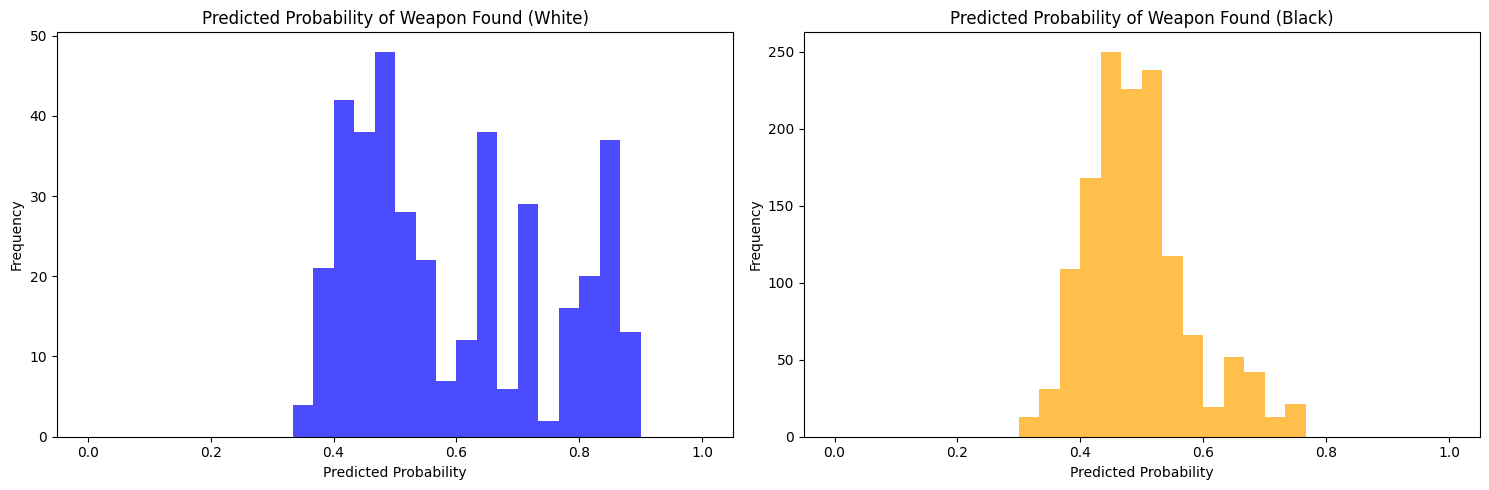

In [ ]:
# Create subplots for white and black races
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# Filter the testing data for subjects with race white and make predictions
feat_white = feat_te[feat_te['race_W'] == 1]  # Assuming 'race' represents the race category for white
predictions_white = best_rf_regressor.predict(feat_white)

# Create histogram for white race
axes[0].hist(predictions_white, bins=30, range=(0, 1), color='blue', alpha=0.7)
axes[0].set_title('Predicted Probability of Weapon Found (White)')
axes[0].set_xlabel('Predicted Probability')
axes[0].set_ylabel('Frequency')

# Filter the testing data for subjects with race black and make predictions
feat_black = feat_te[feat_te['race_B'] == 1]  # Assuming 'race' represents the race category for black
predictions_black = best_rf_regressor.predict(feat_black)

# Create histogram for black race
axes[1].hist(predictions_black, bins=30, range=(0, 1), color='orange', alpha=0.7)
axes[1].set_title('Predicted Probability of Weapon Found (Black)')
axes[1].set_xlabel('Predicted Probability')
axes[1].set_ylabel('Frequency')

# Show the plots
plt.tight_layout()
plt.show()


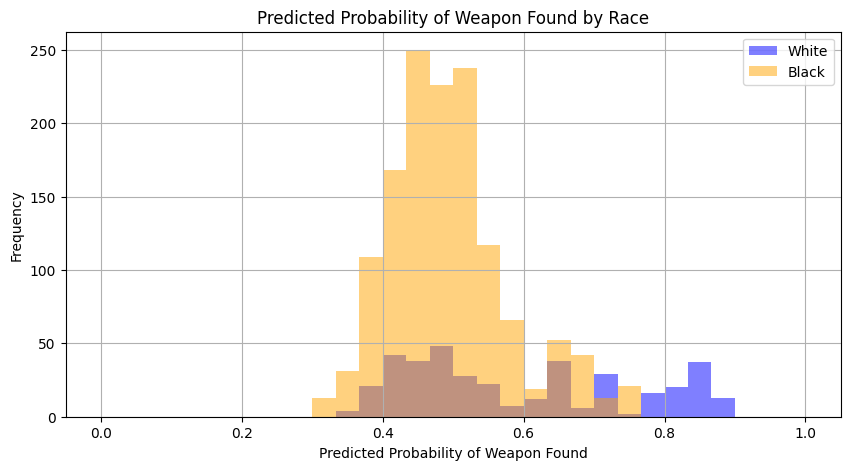

In [ ]:
# Create histograms
plt.figure(figsize=(10, 5))
plt.hist(predictions_white, bins=30, range=(0, 1), alpha=0.5, color='blue', label='White')
plt.hist(predictions_black, bins=30, range=(0, 1), alpha=0.5, color='orange', label='Black')
plt.xlabel('Predicted Probability of Weapon Found')
plt.ylabel('Frequency')
plt.title('Predicted Probability of Weapon Found by Race')
plt.legend()
plt.grid(True)
plt.show()

**Comment on the potential implications of this plot.**

Based on the histograms of predicted probabilities, we observe a shift towards higher probabilities for the white race compared to the black race. This suggests that, on average, the model predicts a higher likelihood of finding a weapon for individuals identified as white compared to those identified as black. Indicating a little Bias in Race.

**Repeat the above (fit a Random Forest Regressor and plot histograms of the predictions of the subsets of the test data for which the subject was white and black) but *removing the subject's race as a feature on which the model is fit*.**

In [ ]:
feat = balanced_df[['perobs', 'inout', 'sex', 'age', 'race']]

# Exclude the 'race' column from the features
feat_no_race = feat[['perobs', 'inout', 'sex', 'age']]

feat_no_race = pd.get_dummies(feat_no_race)

# Split the features into training and testing sets
feat_tr_no_race, feat_te_no_race, targ_tr, targ_te = train_test_split(feat_no_race, targ, test_size=0.2, random_state=302)



# Initialize RandomForestRegressor
rf_regressor_no_race = RandomForestRegressor(random_state=42)

# Initialize GridSearchCV
grid_search_no_race = GridSearchCV(estimator=rf_regressor_no_race, param_grid=param_grid)

# Fit the grid search to the training data
grid_search_no_race.fit(feat_tr_no_race, targ_tr)



# Get the best value of min_samples_leaf
best_min_samples_leaf_no_race = grid_search_no_race.best_params_['min_samples_leaf']

# Get the best model
best_rf_regressor_no_race = grid_search_no_race.best_estimator_


<ipython-input-17-99ef38b27f4c>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  feat_white_no_race = feat_te_no_race[feat['race'] == 'W']  # Assuming 'race' represents the race category for white
<ipython-input-17-99ef38b27f4c>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  feat_black_no_race = feat_te_no_race[feat['race'] == 'B']  # Assuming 'race' represents the race category for black


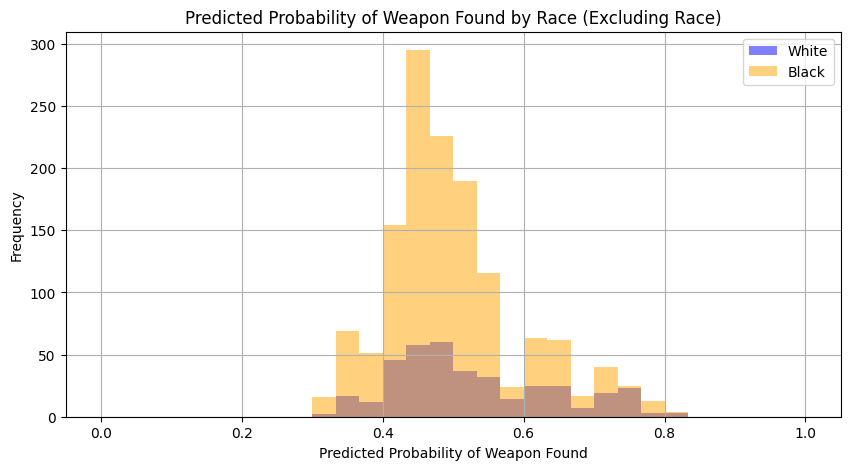

In [ ]:
# Filter the testing data for subjects with race white and make predictions
feat_white_no_race = feat_te_no_race[feat['race'] == 'W']  # Assuming 'race' represents the race category for white
predictions_white_no_race = best_rf_regressor_no_race.predict(feat_white_no_race)

# Filter the testing data for subjects with race black and make predictions
feat_black_no_race = feat_te_no_race[feat['race'] == 'B']  # Assuming 'race' represents the race category for black
predictions_black_no_race = best_rf_regressor_no_race.predict(feat_black_no_race)

# Create histograms
plt.figure(figsize=(10, 5))
plt.hist(predictions_white_no_race, bins=30, range=(0, 1), alpha=0.5, color='blue', label='White')
plt.hist(predictions_black_no_race, bins=30, range=(0, 1), alpha=0.5, color='orange', label='Black')
plt.xlabel('Predicted Probability of Weapon Found')
plt.ylabel('Frequency')
plt.title('Predicted Probability of Weapon Found by Race (Excluding Race)')
plt.legend()
plt.grid(True)
plt.show()

**Assuming that a probability over `0.5` indicates that the model predicts that a weapon will be found on the suspect, is the model that uses the race of a subject as a feature more or less accurate than the model that does not?**

In [ ]:
from sklearn.metrics import accuracy_score

# Predict probabilities for the model with race as a feature
predicted_probs_race = best_rf_regressor.predict(feat_te)

# Predict probabilities for the model without race as a feature
predicted_probs_no_race = best_rf_regressor_no_race.predict(feat_te_no_race)

# Assign binary labels based on the probability threshold of 0.5
labels_race = (predicted_probs_race > 0.5).astype(int)
labels_no_race = (predicted_probs_no_race > 0.5).astype(int)

# Calculate accuracy for the model with race as a feature
accuracy_race = accuracy_score(targ_te, labels_race)

# Calculate accuracy for the model without race as a feature
accuracy_no_race = accuracy_score(targ_te, labels_no_race)

print(accuracy_race)
print(accuracy_no_race)

# Compare accuracies
if accuracy_race > accuracy_no_race:
    print("The model that uses race as a feature is more accurate.")
elif accuracy_race < accuracy_no_race:
    print("The model that does not use race as a feature is more accurate.")
else:
    print("Both models have the same accuracy.")


0.5561681598897312
0.5530668504479669
The model that uses race as a feature is more accurate.
